[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

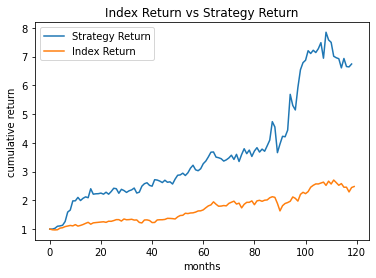

In [3]:
# =============================================================================
# Backtesting strategy - I : Monthly portfolio rebalancing
# Author : Mayank Rasu (http://rasuquant.com/wp/)

# Please report bug/issues in the Q&A section
# =============================================================================

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

# Download historical data (monthly) for DJI constituent stocks

#tickers = ["TSLA", "MSFT" ] 


tickers = ["MMM","AXP","T","BA","CAT","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UNH","VZ","V","WMT","DIS", "TSLA"]

ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

################################Backtesting####################################

# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)


# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df


#calculating overall strategy's KPIs
CAGR(pflio(return_df,6,3))
sharpe(pflio(return_df,6,3),0.025)
max_dd(pflio(return_df,6,3)) 

#calculating KPIs for Index buy and hold strategy over the same period
DJI = yf.download("^DJI",dt.date.today()-dt.timedelta(3650),dt.date.today(),interval='1mo')
DJI["mon_ret"] = DJI["Adj Close"].pct_change().fillna(0)
CAGR(DJI)
sharpe(DJI,0.025)
max_dd(DJI)

#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])

AttributeError: 'function' object has no attribute 'head'

In [7]:
DJI.head()

,Open,High,Low,Close,Adj Close,Volume,mon_ret
Date,,,,,,,
2012-09-01,13092.150391,13653.240234,12977.089844,13437.129883,13437.129883,2701270000,0.000000
2012-10-01,13437.660156,13661.870117,13017.370117,13096.459961,13096.459961,2472600000,-0.025353
2012-11-01,13099.190430,13290.750000,12471.490234,13025.580078,13025.580078,2683930000,-0.005412
2012-12-01,13027.730469,13365.860352,12883.889648,13104.139648,13104.139648,2666750000,0.006031
2013-01-01,13104.299805,13969.990234,13104.299805,13860.580078,13860.580078,2786680000,0.057725


In [8]:
# ============================================================================
# Greenblatt's Magic Formula Implementation
# Author - Mayank Rasu

# Please report bugs/issues in the Q&A section
# =============================================================================


import requests
from bs4 import BeautifulSoup
import pandas as pd

tickers = ["MMM","AXP","AAPL","BA","CAT","CVX","CSCO","KO","DIS","DWDP",
           "XOM","GE","GS","HD","IBM","INTC","JNJ","JPM","MCD","MRK",
           "MSFT","NKE","PFE","PG","TRV","UTX","UNH","VZ","V","WMT"]

#list of tickers whose financial data needs to be extracted
financial_dir = {}



for ticker in tickers:
    #getting balance sheet data from yahoo finance for the given ticker
    temp_dir = {}
    url = 'https://in.finance.yahoo.com/quote/'+ticker+'/balance-sheet?p='+ticker
    print(url)
    page = requests.get(url)
    page_content = page.content
    soup = BeautifulSoup(page_content,'html.parser')
    tabl = soup.find_all("table", {"class" : "Lh(1.7) W(100%) M(0)"})
    for t in tabl:
        rows = t.find_all("tr")
        for row in rows:
            if len(row.get_text(separator='|').split("|")[0:2])>1:
                temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[1]
    
    #getting income statement data from yahoo finance for the given ticker
    url = 'https://in.finance.yahoo.com/quote/'+ticker+'/financials?p='+ticker
    page = requests.get(url)
    page_content = page.content
    soup = BeautifulSoup(page_content,'html.parser')
    tabl = soup.find_all("table", {"class" : "Lh(1.7) W(100%) M(0)"})
    for t in tabl:
        rows = t.find_all("tr")
        for row in rows:
            if len(row.get_text(separator='|').split("|")[0:2])>1:
                temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[1]
    
    #getting cashflow statement data from yahoo finance for the given ticker
    url = 'https://in.finance.yahoo.com/quote/'+ticker+'/cash-flow?p='+ticker
    page = requests.get(url)
    page_content = page.content
    soup = BeautifulSoup(page_content,'html.parser')
    tabl = soup.find_all("table", {"class" : "Lh(1.7) W(100%) M(0)"})
    for t in tabl:
        rows = t.find_all("tr")
        for row in rows:
            if len(row.get_text(separator='|').split("|")[0:2])>1:
                temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[1]
    
    #getting key statistics data from yahoo finance for the given ticker
    url = 'https://in.finance.yahoo.com/quote/'+ticker+'/key-statistics?p='+ticker
    page = requests.get(url)
    page_content = page.content
    soup = BeautifulSoup(page_content,'html.parser')
    tabl = soup.findAll("table", {"class": "table-qsp-stats Mt(10px)"})
    for t in tabl:
        rows = t.find_all("tr")
        for row in rows:
            if len(row.get_text(separator='|').split("|")[0:2])>0:
                temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[-1]    
    
    #combining all extracted information with the corresponding ticker
    financial_dir[ticker] = temp_dir


#storing information in pandas dataframe
combined_financials = pd.DataFrame(financial_dir)
combined_financials.dropna(how='all',axis=1,inplace=True) #dropping columns with all NaN values
tickers = combined_financials.columns #updating the tickers list based on only those tickers whose values were successfully extracted

# creating dataframe with relevant financial information for each stock using fundamental data
stats = ["Earnings before interest and taxes",
         "Market cap (intra-day)",
         "Net income applicable to common shares",
         "Total cash flow from operating activities",
         "Capital expenditure",
         "Total current assets",
         "Total current liabilities",
         "Property plant and equipment",
         "Total stockholder equity",
         "Long-term debt",
         "Preferred stock",
         "Minority interest",
         "Forward annual dividend yield"] # change as required

indx = ["EBIT","MarketCap","NetIncome","CashFlowOps","Capex","CurrAsset",
        "CurrLiab","PPE","BookValue","TotDebt","PrefStock","MinInterest","DivYield"]
all_stats = {}
for ticker in tickers:
    try:
        temp = combined_financials[ticker]
        ticker_stats = []
        for stat in stats:
            ticker_stats.append(temp.loc[stat])
        all_stats['{}'.format(ticker)] = ticker_stats
    except:
        print("can't read data for ",ticker)

all_stats_df = pd.DataFrame(all_stats,index=indx)

# cleansing of fundamental data imported in dataframe
all_stats_df.iloc[1,:] = [x.replace("M","E+03") for x in all_stats_df.iloc[1,:].values]
all_stats_df.iloc[1,:] = [x.replace("B","E+06") for x in all_stats_df.iloc[1,:].values]
all_stats_df.iloc[1,:] = [x.replace("T","E+09") for x in all_stats_df.iloc[1,:].values]
all_stats_df.iloc[-1,:] = [str(x).replace("%","E-02") for x in all_stats_df.iloc[-1,:].values]
all_stats_df[tickers] = all_stats_df[tickers].replace({',': ''}, regex=True)
for ticker in all_stats_df.columns:
    all_stats_df[ticker] = pd.to_numeric(all_stats_df[ticker].values,errors='coerce')

# calculating relevant financial metrics for each stock
transpose_df = all_stats_df.transpose()
final_stats_df = pd.DataFrame()
final_stats_df["EBIT"] = transpose_df["EBIT"]
final_stats_df["TEV"] =  transpose_df["MarketCap"].fillna(0) \
                         +transpose_df["TotDebt"].fillna(0) \
                         +transpose_df["PrefStock"].fillna(0) \
                         +transpose_df["MinInterest"].fillna(0) \
                         -(transpose_df["CurrAsset"].fillna(0)-transpose_df["CurrLiab"].fillna(0))
final_stats_df["EarningYield"] =  final_stats_df["EBIT"]/final_stats_df["TEV"]
final_stats_df["FCFYield"] = (transpose_df["CashFlowOps"]-transpose_df["Capex"])/transpose_df["MarketCap"]
final_stats_df["ROC"]  = transpose_df["EBIT"]/(transpose_df["PPE"]+transpose_df["CurrAsset"]-transpose_df["CurrLiab"])
final_stats_df["BookToMkt"] = transpose_df["BookValue"]/transpose_df["MarketCap"]
final_stats_df["DivYield"] = transpose_df["DivYield"]


################################Output Dataframes##############################

# finding value stocks based on Magic Formula
final_stats_val_df = final_stats_df.loc[tickers,:]
final_stats_val_df["CombRank"] = final_stats_val_df["EarningYield"].rank(ascending=False,na_option='bottom')+final_stats_val_df["ROC"].rank(ascending=False,na_option='bottom')
final_stats_val_df["MagicFormulaRank"] = final_stats_val_df["CombRank"].rank(method='first')
value_stocks = final_stats_val_df.sort_values("MagicFormulaRank").iloc[:,[2,4,8]]
print("------------------------------------------------")
print("Value stocks based on Greenblatt's Magic Formula")
print(value_stocks)


# finding highest dividend yield stocks
high_dividend_stocks = final_stats_df.sort_values("DivYield",ascending=False).iloc[:,6]
print("------------------------------------------------")
print("Highest dividend paying stocks")
print(high_dividend_stocks)


# # Magic Formula & Dividend yield combined
final_stats_df["CombRank"] = final_stats_df["EarningYield"].rank(ascending=False,method='first') \
                              +final_stats_df["ROC"].rank(ascending=False,method='first')  \
                              +final_stats_df["DivYield"].rank(ascending=False,method='first')
final_stats_df["CombinedRank"] = final_stats_df["CombRank"].rank(method='first')
value_high_div_stocks = final_stats_df.sort_values("CombinedRank").iloc[:,[2,4,6,8]]
print("------------------------------------------------")
print("Magic Formula and Dividend Yield combined")
print(value_high_div_stocks)


https://in.finance.yahoo.com/quote/MMM/balance-sheet?p=MMM
https://in.finance.yahoo.com/quote/AXP/balance-sheet?p=AXP
https://in.finance.yahoo.com/quote/AAPL/balance-sheet?p=AAPL
https://in.finance.yahoo.com/quote/BA/balance-sheet?p=BA
https://in.finance.yahoo.com/quote/CAT/balance-sheet?p=CAT
https://in.finance.yahoo.com/quote/CVX/balance-sheet?p=CVX
https://in.finance.yahoo.com/quote/CSCO/balance-sheet?p=CSCO
https://in.finance.yahoo.com/quote/KO/balance-sheet?p=KO
https://in.finance.yahoo.com/quote/DIS/balance-sheet?p=DIS
https://in.finance.yahoo.com/quote/DWDP/balance-sheet?p=DWDP
https://in.finance.yahoo.com/quote/XOM/balance-sheet?p=XOM
https://in.finance.yahoo.com/quote/GE/balance-sheet?p=GE
https://in.finance.yahoo.com/quote/GS/balance-sheet?p=GS
https://in.finance.yahoo.com/quote/HD/balance-sheet?p=HD
https://in.finance.yahoo.com/quote/IBM/balance-sheet?p=IBM
https://in.finance.yahoo.com/quote/INTC/balance-sheet?p=INTC
https://in.finance.yahoo.com/quote/JNJ/balance-sheet?p=JNJ

In [11]:
# ============================================================================
# Greenblatt's Magic Formula Implementation
# Author - Mayank Rasu

# Please report bugs/issues in the Q&A section
# =============================================================================

import requests
from bs4 import BeautifulSoup
import pandas as pd

tickers =  ["MMM","AXP","AAPL","BA","CAT","CVX","CSCO","KO","DIS",
           "XOM","GE","GS","HD","IBM","INTC","JNJ","JPM","MCD","MRK",
           "MSFT","NKE","PFE","PG","TRV","UTX","UNH","VZ","V","WMT"]

#list of tickers whose financial data needs to be extracted
financial_dir = {}

for ticker in tickers:
    try:
        print("scraping financial statement data for ",ticker)
        #getting balance sheet data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Balance%20Sheet&sort=desc".format(ticker)
        df1 = pd.read_excel(url)
        #getting income statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Income%20Statement&sort=desc".format(ticker)
        df2 = pd.read_excel(url)
        #getting cashflow statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Cash%20Flow&sort=desc".format(ticker)
        df3 = pd.read_excel(url)
        
        #getting key statistics data from yahoo finance for the given ticker
        temp_dir = {}
        url = 'https://finance.yahoo.com/quote/'+ticker+'/key-statistics?p='+ticker
        headers={'User-Agent': "Mozilla/5.0"}
        page = requests.get(url, headers=headers)
        page_content = page.content
        soup = BeautifulSoup(page_content,'html.parser')
        tabl = soup.findAll("table", {"class": "W(100%) Bdcl(c)"})
        for t in tabl:
            rows = t.find_all("tr")
            for row in rows:
                if len(row.get_text(separator='|').split("|")[0:2])>0:
                    temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[-1]
        df4 = pd.DataFrame(temp_dir.items(),columns=df3.columns[0:2])
        df4.iloc[:,1] = df4.iloc[:,1].replace({'M': 'E+03','B': 'E+06','T': 'E+09','%': 'E-02'}, regex=True)
        df4.iloc[:,1] = pd.to_numeric(df4.iloc[:,1],errors="coerce")
        df4 = df4[df4["Unnamed: 0"].isin(["Market Cap (intraday)","Forward Annual Dividend Yield"])]
        
        #combining all extracted information with the corresponding ticker
        df = pd.concat([df1,df2,df3,df4]).iloc[:,[0,1]]
        columns = df.columns.values
        for i in range(len(columns)):
            if columns[i] == "Unnamed: 0":
                columns[i] = "heading"
            else:
                columns[i] = columns[i].strftime("%Y-%m-%d")
        df.columns = columns
        df.set_index("heading",inplace=True)
        financial_dir[ticker] = df
    except Exception as e:
        print(ticker,":", e)


# creating dataframe with relevant financial information for each stock using fundamental data
stats = ["EBITDA",
         "Depreciation & Amortization",
         "Market Cap (intraday)",
         "Net Income Common",
         "Operating Cash Flow",
         "Capital expenditures",
         "Total current assets",
         "Total current liabilities",
         "Property, Plant, Equpment (Net)",
         "Shareholders Equity (Total)",
         "Long Term Debt (Total)",
         "Forward Annual Dividend Yield"] # change as required

indx = ["EBITDA","D&A","MarketCap","NetIncome","CashFlowOps","Capex","CurrAsset",
        "CurrLiab","PPE","BookValue","TotDebt","DivYield"]

def info_filter(df,stats,indx):
    """function to filter relevant financial information
       df = dataframe to be filtered
       stats = headings to filter
       indx = rename long headings
       lookback = number of years of data to be retained"""
    for stat in stats:
        if stat not in df.index:
            return
    df_new = df.loc[stats,:]
    df_new.rename(dict(zip(stats,indx)),inplace=True)
    return df_new

#applying filtering to the finacials and calculating relevant financial metrics for each stock
transformed_df = {}
for ticker in financial_dir:
    transformed_df[ticker] = info_filter(financial_dir[ticker],stats,indx)
    if transformed_df[ticker] is None:
        del transformed_df[ticker]
        continue
    transformed_df[ticker].loc["EBIT",:] = transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:]
    transformed_df[ticker].loc["TEV",:] =  transformed_df[ticker].loc["MarketCap",:] + \
                                           transformed_df[ticker].loc["TotDebt",:] - \
                                           (transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["EarningYield",:] =  transformed_df[ticker].loc["EBIT",:]/transformed_df[ticker].loc["TEV",:]
    transformed_df[ticker].loc["FCFYield",:] = (transformed_df[ticker].loc["CashFlowOps",:]-transformed_df[ticker].loc["Capex",:])/transformed_df[ticker].loc["MarketCap",:]
    transformed_df[ticker].loc["ROC",:]  = (transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:])/(transformed_df[ticker].loc["PPE",:]+transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["BookToMkt",:] = transformed_df[ticker].loc["BookValue",:]/transformed_df[ticker].loc["MarketCap",:]

################################Output Dataframes##############################
#final_stats_val_df = pd.DataFrame(columns=transformed_df.keys())
for key in transformed_df:
    final_stats_val_df[key] = transformed_df[key].values.flatten()
final_stats_val_df.set_index(transformed_df[key].index,inplace=True)
    

# finding value stocks based on Magic Formula
final_stats_val_df.loc["CombRank",:] = final_stats_val_df.loc["EarningYield",:].rank(ascending=False,na_option='bottom')+final_stats_val_df.loc["ROC",:].rank(ascending=False,na_option='bottom')
final_stats_val_df.loc["MagicFormulaRank",:] = final_stats_val_df.loc["CombRank",:].rank(method='first')
value_stocks = final_stats_val_df.loc["MagicFormulaRank",:].sort_values()
print("------------------------------------------------")
print("Value stocks based on Greenblatt's Magic Formula")
print(value_stocks)


# finding highest dividend yield stocks
high_dividend_stocks = final_stats_val_df.loc["DivYield",:].sort_values(ascending=False)
print("------------------------------------------------")
print("Highest dividend paying stocks")
print(high_dividend_stocks)

# # Magic Formula & Dividend yield combined
final_stats_val_df.loc["CombinedRank",:] =  final_stats_val_df.loc["EarningYield",:].rank(ascending=False,method='first') \
                                           +final_stats_val_df.loc["ROC",:].rank(ascending=False,method='first')  \
                                           +final_stats_val_df.loc["DivYield",:].rank(ascending=False,method='first')
value_high_div_stocks = final_stats_val_df.T.sort_values("CombinedRank").loc[:,["EarningYield","ROC","DivYield","CombinedRank"]]
print("------------------------------------------------")
print("Magic Formula and Dividend Yield combined")
print(value_high_div_stocks)


scraping financial statement data for  MMM
scraping financial statement data for  AXP
scraping financial statement data for  AAPL
scraping financial statement data for  BA
scraping financial statement data for  CAT
scraping financial statement data for  CVX
scraping financial statement data for  CSCO
scraping financial statement data for  KO
scraping financial statement data for  DIS
scraping financial statement data for  XOM
scraping financial statement data for  GE
scraping financial statement data for  GS
scraping financial statement data for  HD
scraping financial statement data for  IBM
scraping financial statement data for  INTC
scraping financial statement data for  JNJ
scraping financial statement data for  JPM
scraping financial statement data for  MCD
scraping financial statement data for  MRK
scraping financial statement data for  MSFT
scraping financial statement data for  NKE
scraping financial statement data for  PFE
scraping financial statement data for  PG
scraping fina

KeyError: 'EarningYield'

In [25]:
# ============================================================================
# Greenblatt's Magic Formula Implementation
# Author - Mayank Rasu

# Please report bugs/issues in the Q&A section
# =============================================================================

import requests
from bs4 import BeautifulSoup
import pandas as pd

tickers = ["TSLA"]

#list of tickers whose financial data needs to be extracted
financial_dir = {}



for ticker in tickers:
    try:
        print("scraping financial statement data for ",ticker)
        #getting balance sheet data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Balance%20Sheet&sort=desc".format(ticker)
        df1 = pd.read_excel(url)
        #getting income statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Income%20Statement&sort=desc".format(ticker)
        df2 = pd.read_excel(url)
        #getting cashflow statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Cash%20Flow&sort=desc".format(ticker)
        df3 = pd.read_excel(url)
        
        #getting key statistics data from yahoo finance for the given ticker
        temp_dir = {}
        url = 'https://finance.yahoo.com/quote/'+ticker+'/key-statistics?p='+ticker
        headers={'User-Agent': "104.0.5112.79"}
        page = requests.get(url, headers=headers)
        page_content = page.content
        soup = BeautifulSoup(page_content,'html.parser')
        tabl = soup.findAll("table", {"class": "W(100%) Bdcl(c) "}) # try to remove the leading space if the code breaks "class": "W(100%) Bdcl(c)"
        for t in tabl:
            rows = t.find_all("tr")
            for row in rows:
                if len(row.get_text(separator='|').split("|")[0:2])>0:
                    temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[-1]
        df4 = pd.DataFrame(temp_dir.items(),columns=df3.columns[0:2])
        df4.iloc[:,1] = df4.iloc[:,1].replace({'M': 'E+03','B': 'E+06','T': 'E+09','%': 'E-02'}, regex=True)
        df4.iloc[:,1] = pd.to_numeric(df4.iloc[:,1],errors="coerce")
        df4 = df4[df4["Unnamed: 0"].isin(["Market Cap (intraday)","Forward Annual Dividend Yield"])]
        
        #combining all extracted information with the corresponding ticker
        df = pd.concat([df1,df2,df3,df4]).iloc[:,[0,1]]
        columns = df.columns.values
        for i in range(len(columns)):
            if columns[i] == "Unnamed: 0":
                columns[i] = "heading"
            else:
                columns[i] = columns[i].strftime("%Y-%m-%d")
        df.columns = columns
        df.set_index("heading",inplace=True)
        financial_dir[ticker] = df
    except Exception as e:
        print(ticker,":", e)


# creating dataframe with relevant financial information for each stock using fundamental data
stats = ["EBITDA",
         "Depreciation & Amortization",
         "Market Cap (intraday)",
         "Net Income Common",
         "Operating Cash Flow",
         "Capital expenditures",
         "Total current assets",
         "Total current liabilities",
         "Property, Plant, Equpment (Net)",
         "Shareholders Equity (Total)",
         "Long Term Debt (Total)",
         "Forward Annual Dividend Yield"] # change as required

indx = ["EBITDA","D&A","MarketCap","NetIncome","CashFlowOps","Capex","CurrAsset",
        "CurrLiab","PPE","BookValue","TotDebt","DivYield"]

def info_filter(df,stats,indx):
    """function to filter relevant financial information
       df = dataframe to be filtered
       stats = headings to filter
       indx = rename long headings
       lookback = number of years of data to be retained"""
    for stat in stats:
        if stat not in df.index:
            return
    df_new = df.loc[stats,:]
    df_new.rename(dict(zip(stats,indx)),inplace=True)
    return df_new

#applying filtering to the finacials and calculating relevant financial metrics for each stock
transformed_df = {}
for ticker in financial_dir:
    transformed_df[ticker] = info_filter(financial_dir[ticker],stats,indx)
    if transformed_df[ticker] is None:
        del transformed_df[ticker]
        continue
    transformed_df[ticker].loc["EBIT",:] = transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:]
    transformed_df[ticker].loc["TEV",:] =  transformed_df[ticker].loc["MarketCap",:] + \
                                           transformed_df[ticker].loc["TotDebt",:] - \
                                           (transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["EarningYield",:] =  transformed_df[ticker].loc["EBIT",:]/transformed_df[ticker].loc["TEV",:]
    transformed_df[ticker].loc["FCFYield",:] = (transformed_df[ticker].loc["CashFlowOps",:]-transformed_df[ticker].loc["Capex",:])/transformed_df[ticker].loc["MarketCap",:]
    transformed_df[ticker].loc["ROC",:]  = (transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:])/(transformed_df[ticker].loc["PPE",:]+transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["BookToMkt",:] = transformed_df[ticker].loc["BookValue",:]/transformed_df[ticker].loc["MarketCap",:]

################################Output Dataframes##############################
final_stats_val_df = pd.DataFrame(columns=transformed_df.keys())
#for key in transformed_df:
    #final_stats_val_df[key] = transformed_df[key].values.flatten()
#final_stats_val_df.set_index(transformed_df[key].index,inplace=True)
    

# finding value stocks based on Magic Formula
final_stats_val_df.loc["CombRank",:] = final_stats_val_df.loc["EarningYield",:].rank(ascending=False,na_option='bottom')+final_stats_val_df.loc["ROC",:].rank(ascending=False,na_option='bottom')
final_stats_val_df.loc["MagicFormulaRank",:] = final_stats_val_df.loc["CombRank",:].rank(method='first')
value_stocks = final_stats_val_df.loc["MagicFormulaRank",:].sort_values()
print("------------------------------------------------")
print("Value stocks based on Greenblatt's Magic Formula")
print(value_stocks)


# finding highest dividend yield stocks
high_dividend_stocks = final_stats_val_df.loc["DivYield",:].sort_values(ascending=False)
print("------------------------------------------------")
print("Highest dividend paying stocks")
print(high_dividend_stocks)

# # Magic Formula & Dividend yield combined
final_stats_val_df.loc["CombinedRank",:] =  final_stats_val_df.loc["EarningYield",:].rank(ascending=False,method='first') \
                                           +final_stats_val_df.loc["ROC",:].rank(ascending=False,method='first')  \
                                           +final_stats_val_df.loc["DivYield",:].rank(ascending=False,method='first')
value_high_div_stocks = final_stats_val_df.T.sort_values("CombinedRank").loc[:,["EarningYield","ROC","DivYield","CombinedRank"]]
print("------------------------------------------------")
print("Magic Formula and Dividend Yield combined")
print(value_high_div_stocks)


scraping financial statement data for  TSLA


KeyError: 'EarningYield'

In [3]:
# ============================================================================
# Piotroski f score implementation
# Author - Mayank Rasu

# Please report bugs/issues in the Q&A section
# =============================================================================

import pandas as pd

tickers = ["AXP","AAPL","BA","CAT","CVX","CSCO","DIS","DOW", "XOM",
           "HD","IBM","INTC","JNJ","KO","MCD","MMM","MRK","MSFT",
           "NKE","PFE","PG","UNH","VZ","V","WMT","WBA", "TSLA"]

#list of tickers whose financial data needs to be extracted
financial_dir = {} #directory to store financial information for each ticker



for ticker in tickers:
    try:
        print("scraping financial statement data for ",ticker)
        #getting balance sheet data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Balance%20Sheet&sort=desc".format(ticker)
        df1 = pd.read_excel(url)
        #getting income statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Income%20Statement&sort=desc".format(ticker)
        df2 = pd.read_excel(url)
        #getting cashflow statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Cash%20Flow&sort=desc".format(ticker)
        df3 = pd.read_excel(url)
        #combining all extracted information with the corresponding ticker
        df = pd.concat([df1,df2,df3])
        columns = df.columns.values
        for i in range(len(columns)):
            if columns[i] == "Unnamed: 0":
                columns[i] = "heading"
            else:
                columns[i] = columns[i].strftime("%Y-%m-%d")
        df.columns = columns
        df.set_index("heading",inplace=True)
        financial_dir[ticker] = df
    except Exception as e:
        print(ticker,":", e)


# selecting relevant financial information for each stock using fundamental data
stats = ["Net Income Common",
         "Total Assets",
         "Operating Cash Flow",
         "Long Term Debt (Total)",
         "Total non-current liabilities",
         "Total current assets",
         "Total current liabilities",
         "Common Equity (Total)",
         "Revenue",
         "Gross Profit"] # change as required

indx = ["NetIncome","TotAssets","CashFlowOps","LTDebt","TotLTLiab",
        "CurrAssets","CurrLiab","CommStock","TotRevenue","GrossProfit"]


def info_filter(df,stats,indx,lookback):
    """function to filter relevant financial information
       df = dataframe to be filtered
       stats = headings to filter
       indx = rename long headings
       lookback = number of years of data to be retained"""
    df_new = df.loc[stats,df.columns[:3]]
    df_new.rename(dict(zip(stats,indx)),inplace=True)
    df_new.loc["OtherLTDebt",:] = df_new.loc["TotLTLiab",:] - df_new.loc["LTDebt",:]
    return df_new

#applying filtering to the finacials
transformed_df = {}
for ticker in financial_dir:
    transformed_df[ticker] = info_filter(financial_dir[ticker],stats,indx,3)


def piotroski_f(df_dict):
    """function to calculate f score of each stock and output information as dataframe"""
    f_score = {}
    for ticker in df_dict:
        columns = df_dict[ticker].columns
        ROA_FS = int(df_dict[ticker].loc["NetIncome",columns[0]]/((df_dict[ticker].loc["TotAssets",columns[0]] + df_dict[ticker].loc["TotAssets",columns[1]])/2) > 0)
        CFO_FS = int(df_dict[ticker].loc["CashFlowOps",columns[0]] > 0)
        ROA_D_FS = int((df_dict[ticker].loc["NetIncome",columns[0]]/((df_dict[ticker].loc["TotAssets",columns[0]] + df_dict[ticker].loc["TotAssets",columns[1]])/2)) > (df_dict[ticker].loc["NetIncome",columns[1]]/((df_dict[ticker].loc["TotAssets",columns[1]] + df_dict[ticker].loc["TotAssets",columns[2]])/2)))
        CFO_ROA_FS = int(df_dict[ticker].loc["CashFlowOps",columns[0]]/df_dict[ticker].loc["TotAssets",columns[0]] > df_dict[ticker].loc["NetIncome",columns[0]]/((df_dict[ticker].loc["TotAssets",columns[0]] + df_dict[ticker].loc["TotAssets",columns[1]])/2))
        LTD_FS = int((df_dict[ticker].loc["LTDebt",columns[0]] + df_dict[ticker].loc["OtherLTDebt",columns[0]]) < (df_dict[ticker].loc["LTDebt",columns[1]] + df_dict[ticker].loc["OtherLTDebt",columns[1]]))
        CR_FS = int((df_dict[ticker].loc["CurrAssets",columns[0]] / df_dict[ticker].loc["CurrLiab",columns[0]]) > (df_dict[ticker].loc["CurrAssets",columns[1]] / df_dict[ticker].loc["CurrLiab",columns[1]]))
        DILUTION_FS = int(df_dict[ticker].loc["CommStock",columns[0]] <= df_dict[ticker].loc["CommStock",columns[1]])
        GM_FS = int((df_dict[ticker].loc["GrossProfit",columns[0]]/df_dict[ticker].loc["TotRevenue",columns[0]]) > (df_dict[ticker].loc["GrossProfit",columns[1]]/df_dict[ticker].loc["TotRevenue",columns[1]]))
        ATO_FS = int((df_dict[ticker].loc["TotRevenue",columns[0]]/((df_dict[ticker].loc["TotAssets",columns[0]] + df_dict[ticker].loc["TotAssets",columns[1]])/2)) > (df_dict[ticker].loc["TotRevenue",columns[1]]/((df_dict[ticker].loc["TotAssets",columns[1]] + df_dict[ticker].loc["TotAssets",columns[2]])/2)))
        f_score[ticker] = [ROA_FS,CFO_FS,ROA_D_FS,CFO_ROA_FS,LTD_FS,CR_FS,DILUTION_FS,GM_FS,ATO_FS]
    f_score_df = pd.DataFrame(f_score,index=["PosROA","PosCFO","ROAChange","Accruals","Leverage","Liquidity","Dilution","GM","ATO"])
    return f_score_df

# sorting stocks with highest Piotroski f score to lowest
f_score_df = piotroski_f(transformed_df)
f_score_df.sum().sort_values(ascending=False)

scraping financial statement data for  AXP
scraping financial statement data for  AAPL
scraping financial statement data for  BA
scraping financial statement data for  CAT
scraping financial statement data for  CVX
scraping financial statement data for  CSCO
scraping financial statement data for  DIS
scraping financial statement data for  DOW
scraping financial statement data for  XOM
scraping financial statement data for  HD
scraping financial statement data for  IBM
scraping financial statement data for  INTC
scraping financial statement data for  JNJ
scraping financial statement data for  KO
scraping financial statement data for  MCD
scraping financial statement data for  MMM
scraping financial statement data for  MRK
scraping financial statement data for  MSFT
scraping financial statement data for  NKE
scraping financial statement data for  PFE
scraping financial statement data for  PG
scraping financial statement data for  UNH
scraping financial statement data for  VZ
scraping fin

AXP     9
JNJ     8
XOM     8
IBM     7
V       7
PFE     7
MRK     7
MCD     7
AAPL    7
KO      7
TSLA    7
DOW     7
DIS     7
CVX     7
CAT     7
WMT     6
MMM     6
PG      6
UNH     6
WBA     6
CSCO    5
MSFT    5
INTC    5
BA      5
HD      4
VZ      4
NKE     4
dtype: int64

In [18]:
final_stats_val_df = pd.DataFrame(columns=transformed_df.keys())
for keys in transformed_df:
    final_stats_val_df[key] = transformed_df[key].values.flatten()
final_stats_val_df.set_index(transformed_df[key].index,inplace=True)
    

ValueError: Length mismatch: Expected 33 rows, received array of length 11

In [14]:
transformed_df

{'AXP':                2021-12-31    2020-12-31    2019-12-31
 heading                                              
 NetIncome    7.917000e+09  3.036000e+09  6.631000e+09
 TotAssets    1.885480e+11  1.913670e+11  1.983210e+11
 CashFlowOps  1.464500e+10  5.591000e+09  1.363200e+10
 LTDebt       2.449200e+10  3.112300e+10  4.222000e+10
 TotLTLiab    6.917200e+10  7.018600e+10  8.278300e+10
 CurrAssets   1.637250e+11  1.470420e+11  1.708640e+11
 CurrLiab     9.719900e+10  9.819700e+10  9.246700e+10
 CommStock    2.217700e+10  2.298400e+10  2.307100e+10
 TotRevenue   4.366300e+10  3.818500e+10  4.702000e+10
 GrossProfit  4.238000e+10  3.608700e+10  4.355600e+10
 OtherLTDebt  4.468000e+10  3.906300e+10  4.056300e+10,
 'AAPL':                2021-09-30    2020-09-30    2019-09-30
 heading                                              
 NetIncome    9.468000e+10  5.741100e+10  5.525600e+10
 TotAssets    3.510020e+11  3.238880e+11  3.385160e+11
 CashFlowOps  1.040380e+11  8.067400e+10  6.93910

In [16]:
final_stats_val_df

,AXP,AAPL,BA,CAT,CVX,CSCO,DIS,DOW,XOM,HD,...,MSFT,NKE,PFE,PG,UNH,VZ,V,WMT,WBA,TSLA
0,7.917000e+09,9.468000e+10,-4.202000e+09,6.489000e+09,1.562500e+10,1.059100e+10,1.995000e+09,6.279000e+09,2.304000e+10,1.643300e+10,...,7.273800e+10,6.046000e+09,2.214600e+10,1.474200e+10,1.728500e+10,2.206500e+10,1.200800e+10,1.367300e+10,2.220000e+09,5.524000e+09
1,3.036000e+09,5.741100e+10,-1.187300e+10,2.998000e+09,-5.543000e+09,1.121400e+10,-2.864000e+09,1.216000e+09,-2.244000e+10,1.286600e+10,...,6.127100e+10,5.727000e+09,9.159000e+09,1.403500e+10,1.540300e+10,1.780100e+10,1.047500e+10,1.351000e+10,4.560000e+08,6.900000e+08
2,6.631000e+09,5.525600e+10,-6.360000e+08,6.093000e+09,2.924000e+09,1.162100e+10,1.105400e+10,-1.365000e+09,1.434000e+10,1.124200e+10,...,4.428100e+10,2.539000e+09,1.627200e+10,1.276400e+10,1.383900e+10,1.926500e+10,1.165000e+10,1.488100e+10,3.982000e+09,-8.700000e+08
3,1.885480e+11,3.510020e+11,1.385520e+11,8.279300e+10,2.395350e+11,9.749700e+10,2.036090e+11,6.299000e+10,3.389230e+11,7.187600e+10,...,3.648400e+11,4.032100e+10,1.814760e+11,1.172080e+11,2.157540e+11,3.665960e+11,8.289600e+10,2.448600e+11,8.128500e+10,6.213100e+10
4,1.913670e+11,3.238880e+11,1.521360e+11,7.832400e+10,2.397900e+11,9.485300e+10,2.015490e+11,6.147000e+10,3.327500e+11,7.058100e+10,...,3.337790e+11,3.774000e+10,1.542290e+11,1.193070e+11,2.006800e+11,3.164810e+11,8.091900e+10,2.524960e+11,8.717400e+10,5.214800e+10
5,1.983210e+11,3.385160e+11,1.336250e+11,7.845300e+10,2.374280e+11,9.779300e+10,1.939840e+11,6.052400e+10,3.625970e+11,5.123600e+10,...,3.013110e+11,3.134200e+10,1.675940e+11,1.207000e+11,1.767570e+11,2.917270e+11,7.257400e+10,2.364950e+11,6.759800e+10,3.430900e+10
6,1.464500e+10,1.040380e+11,-3.416000e+09,7.198000e+09,2.918700e+10,1.545400e+10,5.566000e+09,7.009000e+09,4.812900e+10,1.657100e+10,...,8.903500e+10,5.188000e+09,3.258000e+10,1.672300e+10,2.234300e+10,3.953900e+10,1.522700e+10,2.418100e+10,5.555000e+09,1.149700e+10
7,5.591000e+09,8.067400e+10,-1.841000e+10,6.327000e+09,1.057700e+10,1.542600e+10,7.616000e+09,6.226000e+09,1.466800e+10,1.883900e+10,...,7.674000e+10,6.657000e+09,1.440300e+10,1.837100e+10,2.217400e+10,4.176800e+10,1.044000e+10,3.607400e+10,5.484000e+09,5.943000e+09
8,1.363200e+10,6.939100e+10,-2.446000e+09,6.912000e+09,2.731400e+10,1.583100e+10,5.984000e+09,5.930000e+09,2.971600e+10,1.372300e+10,...,6.067500e+10,2.485000e+09,1.258800e+10,1.740300e+10,1.846300e+10,3.574600e+10,1.278400e+10,2.525500e+10,5.594000e+09,2.405000e+09
9,2.449200e+10,1.193810e+11,5.807700e+10,2.651700e+10,3.111300e+10,9.849000e+09,4.854000e+10,1.542900e+10,4.738200e+10,4.195700e+10,...,7.236300e+10,8.920000e+09,3.870500e+10,2.284800e+10,4.578600e+10,1.666280e+11,2.047800e+10,5.211600e+10,3.080200e+10,6.916000e+09


In [19]:
# ============================================================================
# Greenblatt's Magic Formula Implementation
# Author - Mayank Rasu

# Please report bugs/issues in the Q&A section
# =============================================================================

import requests
from bs4 import BeautifulSoup
import pandas as pd

tickers = ["MMM","AXP","AAPL","BA","CAT","CVX","CSCO","KO","DIS",
           "XOM","GE","GS","HD","IBM","INTC","JNJ","JPM","MCD","MRK",
           "MSFT","NKE","PFE","PG","TRV","UTX","UNH","VZ","V","WMT"]

#list of tickers whose financial data needs to be extracted
financial_dir = {}

for ticker in tickers:
    try:
        print("scraping financial statement data for ",ticker)
        #getting balance sheet data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Balance%20Sheet&sort=desc".format(ticker)
        df1 = pd.read_excel(url)
        #getting income statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Income%20Statement&sort=desc".format(ticker)
        df2 = pd.read_excel(url)
        #getting cashflow statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Cash%20Flow&sort=desc".format(ticker)
        df3 = pd.read_excel(url)
        
        #getting key statistics data from yahoo finance for the given ticker
        temp_dir = {}
        url = 'https://finance.yahoo.com/quote/'+ticker+'/key-statistics?p='+ticker
        headers={'User-Agent': "Mozilla/5.0"}
        page = requests.get(url, headers=headers)
        page_content = page.content
        soup = BeautifulSoup(page_content,'html.parser')
        tabl = soup.findAll("table", {"class": "W(100%) Bdcl(c) "}) # try to remove the leading space if the code breaks "class": "W(100%) Bdcl(c)"
        for t in tabl:
            rows = t.find_all("tr")
            for row in rows:
                if len(row.get_text(separator='|').split("|")[0:2])>0:
                    temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[-1]
        df4 = pd.DataFrame(temp_dir.items(),columns=df3.columns[0:2])
        df4.iloc[:,1] = df4.iloc[:,1].replace({'M': 'E+03','B': 'E+06','T': 'E+09','%': 'E-02'}, regex=True)
        df4.iloc[:,1] = pd.to_numeric(df4.iloc[:,1],errors="coerce")
        df4 = df4[df4["Unnamed: 0"].isin(["Market Cap (intraday)","Forward Annual Dividend Yield"])]
        
        #combining all extracted information with the corresponding ticker
        df = pd.concat([df1,df2,df3,df4]).iloc[:,[0,1]]
        columns = df.columns.values
        for i in range(len(columns)):
            if columns[i] == "Unnamed: 0":
                columns[i] = "heading"
            else:
                columns[i] = columns[i].strftime("%Y-%m-%d")
        df.columns = columns
        df.set_index("heading",inplace=True)
        financial_dir[ticker] = df
    except Exception as e:
        print(ticker,":", e)


# creating dataframe with relevant financial information for each stock using fundamental data
stats = ["EBITDA",
         "Depreciation & Amortization",
         "Market Cap (intraday)",
         "Net Income Common",
         "Operating Cash Flow",
         "Capital expenditures",
         "Total current assets",
         "Total current liabilities",
         "Property, Plant, Equpment (Net)",
         "Shareholders Equity (Total)",
         "Long Term Debt (Total)",
         "Forward Annual Dividend Yield"] # change as required

indx = ["EBITDA","D&A","MarketCap","NetIncome","CashFlowOps","Capex","CurrAsset",
        "CurrLiab","PPE","BookValue","TotDebt","DivYield"]

def info_filter(df,stats,indx):
    """function to filter relevant financial information
       df = dataframe to be filtered
       stats = headings to filter
       indx = rename long headings
       lookback = number of years of data to be retained"""
    for stat in stats:
        if stat not in df.index:
            return
    df_new = df.loc[stats,:]
    df_new.rename(dict(zip(stats,indx)),inplace=True)
    return df_new

#applying filtering to the finacials and calculating relevant financial metrics for each stock
transformed_df = {}
for ticker in financial_dir:
    transformed_df[ticker] = info_filter(financial_dir[ticker],stats,indx)
    if transformed_df[ticker] is None:
        del transformed_df[ticker]
        continue
    transformed_df[ticker].loc["EBIT",:] = transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:]
    transformed_df[ticker].loc["TEV",:] =  transformed_df[ticker].loc["MarketCap",:] + \
                                           transformed_df[ticker].loc["TotDebt",:] - \
                                           (transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["EarningYield",:] =  transformed_df[ticker].loc["EBIT",:]/transformed_df[ticker].loc["TEV",:]
    transformed_df[ticker].loc["FCFYield",:] = (transformed_df[ticker].loc["CashFlowOps",:]-transformed_df[ticker].loc["Capex",:])/transformed_df[ticker].loc["MarketCap",:]
    transformed_df[ticker].loc["ROC",:]  = (transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:])/(transformed_df[ticker].loc["PPE",:]+transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["BookToMkt",:] = transformed_df[ticker].loc["BookValue",:]/transformed_df[ticker].loc["MarketCap",:]


scraping financial statement data for  MMM
scraping financial statement data for  AXP
scraping financial statement data for  AAPL
scraping financial statement data for  BA
scraping financial statement data for  CAT
scraping financial statement data for  CVX
scraping financial statement data for  CSCO
scraping financial statement data for  KO
scraping financial statement data for  DIS
scraping financial statement data for  XOM
scraping financial statement data for  GE
scraping financial statement data for  GS
scraping financial statement data for  HD
scraping financial statement data for  IBM
scraping financial statement data for  INTC
scraping financial statement data for  JNJ
scraping financial statement data for  JPM
scraping financial statement data for  MCD
scraping financial statement data for  MRK
scraping financial statement data for  MSFT
scraping financial statement data for  NKE
scraping financial statement data for  PFE
scraping financial statement data for  PG
scraping fina

In [23]:
final_stats_val_df = pd.DataFrame(columns=transformed_df.keys())
for keys in transformed_df:
    final_stats_val_df[key] = transformed_df[key].values.flatten()
final_stats_val_df.set_index(transformed_df[key].index,inplace=True)

KeyError: 'TSLA'

In [ ]:
tickers =  ["MMM","AXP","AAPL","BA","CAT","CVX","CSCO","KO","DIS",
           "XOM","GE","GS","HD","IBM","INTC","JNJ","JPM","MCD","MRK",
           "MSFT","NKE","PFE","PG","TRV","UTX","UNH","VZ","V","WMT"]


In [1]:
# ============================================================================
# Greenblatt's Magic Formula Implementation
# Author - Mayank Rasu

# Please report bugs/issues in the Q&A section
# =============================================================================

import requests
from bs4 import BeautifulSoup
import pandas as pd

tickers =  ["MMM","AXP","AAPL","BA","CAT","CVX","CSCO","KO","DIS",
           "XOM","GE","GS","HD","IBM","INTC","JNJ","JPM","MCD","MRK",
           "MSFT","NKE","PFE","PG","TRV","UTX","UNH","VZ","V","WMT"]

#list of tickers whose financial data needs to be extracted
financial_dir = {}

for ticker in tickers:
    try:
        print("scraping financial statement data for ",ticker)
        #getting balance sheet data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Balance%20Sheet&sort=desc".format(ticker)
        df1 = pd.read_excel(url)
        #getting income statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Income%20Statement&sort=desc".format(ticker)
        df2 = pd.read_excel(url)
        #getting cashflow statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Cash%20Flow&sort=desc".format(ticker)
        df3 = pd.read_excel(url)
        
        #getting key statistics data from yahoo finance for the given ticker
        temp_dir = {}
        url = 'https://finance.yahoo.com/quote/'+ticker+'/key-statistics?p='+ticker
        headers={'User-Agent': "Mozilla/5.0"}
        page = requests.get(url, headers=headers)
        page_content = page.content
        soup = BeautifulSoup(page_content,'html.parser')
        tabl = soup.findAll("table", {"class": "W(100%) Bdcl(c)"})
        for t in tabl:
            rows = t.find_all("tr")
            for row in rows:
                if len(row.get_text(separator='|').split("|")[0:2])>0:
                    temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[-1]
        df4 = pd.DataFrame(temp_dir.items(),columns=df3.columns[0:2])
        df4.iloc[:,1] = df4.iloc[:,1].replace({'M': 'E+03','B': 'E+06','T': 'E+09','%': 'E-02'}, regex=True)
        df4.iloc[:,1] = pd.to_numeric(df4.iloc[:,1],errors="coerce")
        df4 = df4[df4["Unnamed: 0"].isin(["Market Cap (intraday)","Forward Annual Dividend Yield"])]
        
        #combining all extracted information with the corresponding ticker
        df = pd.concat([df1,df2,df3,df4]).iloc[:,[0,1]]
        columns = df.columns.values
        for i in range(len(columns)):
            if columns[i] == "Unnamed: 0":
                columns[i] = "heading"
            else:
                columns[i] = columns[i].strftime("%Y-%m-%d")
        df.columns = columns
        df.set_index("heading",inplace=True)
        financial_dir[ticker] = df
    except Exception as e:
        print(ticker,":", e)


# creating dataframe with relevant financial information for each stock using fundamental data
stats = ["EBITDA",
         "Depreciation & Amortization",
         "Market Cap (intraday)",
         "Net Income Common",
         "Operating Cash Flow",
         "Capital expenditures",
         "Total current assets",
         "Total current liabilities",
         "Property, Plant, Equpment (Net)",
         "Shareholders Equity (Total)",
         "Long Term Debt (Total)",
         "Forward Annual Dividend Yield"] # change as required

indx = ["EBITDA","D&A","MarketCap","NetIncome","CashFlowOps","Capex","CurrAsset",
        "CurrLiab","PPE","BookValue","TotDebt","DivYield"]

def info_filter(df,stats,indx):
    """function to filter relevant financial information
       df = dataframe to be filtered
       stats = headings to filter
       indx = rename long headings
       lookback = number of years of data to be retained"""
    for stat in stats:
        if stat not in df.index:
            return
    df_new = df.loc[stats,:]
    df_new.rename(dict(zip(stats,indx)),inplace=True)
    return df_new

#applying filtering to the finacials and calculating relevant financial metrics for each stock
transformed_df = {}
for ticker in financial_dir:
    transformed_df[ticker] = info_filter(financial_dir[ticker],stats,indx)
    if transformed_df[ticker] is None:
        del transformed_df[ticker]
        continue
    transformed_df[ticker].loc["EBIT",:] = transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:]
    transformed_df[ticker].loc["TEV",:] =  transformed_df[ticker].loc["MarketCap",:] + \
                                           transformed_df[ticker].loc["TotDebt",:] - \
                                           (transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["EarningYield",:] =  transformed_df[ticker].loc["EBIT",:]/transformed_df[ticker].loc["TEV",:]
    transformed_df[ticker].loc["FCFYield",:] = (transformed_df[ticker].loc["CashFlowOps",:]-transformed_df[ticker].loc["Capex",:])/transformed_df[ticker].loc["MarketCap",:]
    transformed_df[ticker].loc["ROC",:]  = (transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:])/(transformed_df[ticker].loc["PPE",:]+transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["BookToMkt",:] = transformed_df[ticker].loc["BookValue",:]/transformed_df[ticker].loc["MarketCap",:]


scraping financial statement data for  MMM
scraping financial statement data for  AXP
scraping financial statement data for  AAPL
scraping financial statement data for  BA
scraping financial statement data for  CAT
scraping financial statement data for  CVX
scraping financial statement data for  CSCO
scraping financial statement data for  KO
scraping financial statement data for  DIS
scraping financial statement data for  XOM
scraping financial statement data for  GE
scraping financial statement data for  GS
scraping financial statement data for  HD
scraping financial statement data for  IBM
scraping financial statement data for  INTC
scraping financial statement data for  JNJ
scraping financial statement data for  JPM
scraping financial statement data for  MCD
scraping financial statement data for  MRK
scraping financial statement data for  MSFT
scraping financial statement data for  NKE
scraping financial statement data for  PFE
scraping financial statement data for  PG
scraping fina

In [2]:
transformed_df

{}

In [7]:
# ============================================================================
# Greenblatt's Magic Formula Implementation
# Author - Mayank Rasu

# Please report bugs/issues in the Q&A section
# =============================================================================

import requests
from bs4 import BeautifulSoup
import pandas as pd

tickers = ["MSFT"]

#list of tickers whose financial data needs to be extracted
financial_dir = {}



for ticker in tickers:
    try:
        print("scraping financial statement data for ",ticker)
        #getting balance sheet data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Balance%20Sheet&sort=desc".format(ticker)
        df1 = pd.read_excel(url)
        #getting income statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Income%20Statement&sort=desc".format(ticker)
        df2 = pd.read_excel(url)
        #getting cashflow statement data
        url = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=A&section=Cash%20Flow&sort=desc".format(ticker)
        df3 = pd.read_excel(url)
        
        #getting key statistics data from yahoo finance for the given ticker
        temp_dir = {}
        url = 'https://finance.yahoo.com/quote/'+ticker+'/key-statistics?p='+ticker
        headers={'User-Agent': "104.0.5112.79"}
        page = requests.get(url, headers=headers)
        page_content = page.content
        soup = BeautifulSoup(page_content,'html.parser')
        tabl = soup.findAll("table", {"class": "W(100%) Bdcl(c) "}) # try to remove the leading space if the code breaks "class": "W(100%) Bdcl(c)"
        for t in tabl:
            rows = t.find_all("tr")
            for row in rows:
                if len(row.get_text(separator='|').split("|")[0:2])>0:
                    temp_dir[row.get_text(separator='|').split("|")[0]]=row.get_text(separator='|').split("|")[-1]
        df4 = pd.DataFrame(temp_dir.items(),columns=df3.columns[0:2])
        df4.iloc[:,1] = df4.iloc[:,1].replace({'M': 'E+03','B': 'E+06','T': 'E+09','%': 'E-02'}, regex=True)
        df4.iloc[:,1] = pd.to_numeric(df4.iloc[:,1],errors="coerce")
        df4 = df4[df4["Unnamed: 0"].isin(["Market Cap (intraday)","Forward Annual Dividend Yield"])]
        
        #combining all extracted information with the corresponding ticker
        df = pd.concat([df1,df2,df3,df4]).iloc[:,[0,1]]
        columns = df.columns.values
        for i in range(len(columns)):
            if columns[i] == "Unnamed: 0":
                columns[i] = "heading"
            else:
                columns[i] = columns[i].strftime("%Y-%m-%d")
        df.columns = columns
        df.set_index("heading",inplace=True)
        financial_dir[ticker] = df
    except Exception as e:
        print(ticker,":", e)


# creating dataframe with relevant financial information for each stock using fundamental data
stats = ["EBITDA",
         "Depreciation & Amortization",
         "Market Cap (intraday)",
         "Net Income Common",
         "Operating Cash Flow",
         "Capital expenditures",
         "Total current assets",
         "Total current liabilities",
         "Property, Plant, Equpment (Net)",
         "Shareholders Equity (Total)",
         "Long Term Debt (Total)",
         "Forward Annual Dividend Yield"] # change as required

indx = ["EBITDA","D&A","MarketCap","NetIncome","CashFlowOps","Capex","CurrAsset",
        "CurrLiab","PPE","BookValue","TotDebt","DivYield"]

def info_filter(df,stats,indx):
    """function to filter relevant financial information
       df = dataframe to be filtered
       stats = headings to filter
       indx = rename long headings
       lookback = number of years of data to be retained"""
    for stat in stats:
        if stat not in df.index:
            return
    df_new = df.loc[stats,:]
    df_new.rename(dict(zip(stats,indx)),inplace=True)
    return df_new

#applying filtering to the finacials and calculating relevant financial metrics for each stock
transformed_df = {}
for ticker in financial_dir:
    transformed_df[ticker] = info_filter(financial_dir[ticker],stats,indx)
    if transformed_df[ticker] is None:
        del transformed_df[ticker]
        continue
    transformed_df[ticker].loc["EBIT",:] = transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:]
    transformed_df[ticker].loc["TEV",:] =  transformed_df[ticker].loc["MarketCap",:] + \
                                           transformed_df[ticker].loc["TotDebt",:] - \
                                           (transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["EarningYield",:] =  transformed_df[ticker].loc["EBIT",:]/transformed_df[ticker].loc["TEV",:]
    transformed_df[ticker].loc["FCFYield",:] = (transformed_df[ticker].loc["CashFlowOps",:]-transformed_df[ticker].loc["Capex",:])/transformed_df[ticker].loc["MarketCap",:]
    transformed_df[ticker].loc["ROC",:]  = (transformed_df[ticker].loc["EBITDA",:] - transformed_df[ticker].loc["D&A",:])/(transformed_df[ticker].loc["PPE",:]+transformed_df[ticker].loc["CurrAsset",:]-transformed_df[ticker].loc["CurrLiab",:])
    transformed_df[ticker].loc["BookToMkt",:] = transformed_df[ticker].loc["BookValue",:]/transformed_df[ticker].loc["MarketCap",:]

scraping financial statement data for  MSFT


KeyError: 'MSFT'